In [1]:
import numpy as np
import pickle as pkl
import torch
import umap
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.tableau import Tableau_20 as pallette

from WaveletVAE.experiments.configs.demo_config import get_demo_config
from SignalTransformData.data_modules.simulated import SinusoidalDataModule

sns.set()
sns.set_palette(pallette.mpl_colors)

# sns.set_palette(ListedColormap(palette.mpl_colormap))
# style.use('seaborn')


In [2]:
config = get_demo_config()
classes = len(config["bias"])
channels = len(config["bias"][0])
length = 512
print(f"{classes} classes, with {channels} channels")

dm = SinusoidalDataModule(config, samples=2000, batch_size=128, sig_length=length)
lbl, lbl_idx = np.unique(dm.labels, return_index=True)
X = dm.signals_no_noise[lbl_idx, :].reshape((6, -1))

6 classes, with 2 channels


# Make data dataframe

In [3]:
data = []

# Class 1 and 2
# No distinction in resolution sources
for res in ["Low-resolution", "Mid-resolution", "High-resolution"]:
    for cls in [0, 1]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])

# Class 3 and 4
# Distinction at middle resolution
for res in ["Low-resolution"]:
    for cls in [2, 3]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[2, i]])
for res in ["Mid-resolution", "High-resolution"]:
    for cls in [2, 3]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])
            
# Class 5 and 6
# Distinction at high resolution
for res in ["Low-resolution", "Mid-resolution"]:
    for cls in [4, 5]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[4, i]])
for res in ["High-resolution"]:
    for cls in [4, 5]:
        for i in range(length*channels):
            data.append([i, res, cls + 1, X[cls, i]])

In [4]:
df = pd.DataFrame(data, columns=["loci", "resolution", "class", "signal"])
df.head()

,loci,resolution,class,signal
0,0,Low-resolution,1,0.000000
1,1,Low-resolution,1,-0.000009
2,2,Low-resolution,1,-0.000038
3,3,Low-resolution,1,-0.000085
4,4,Low-resolution,1,-0.000151


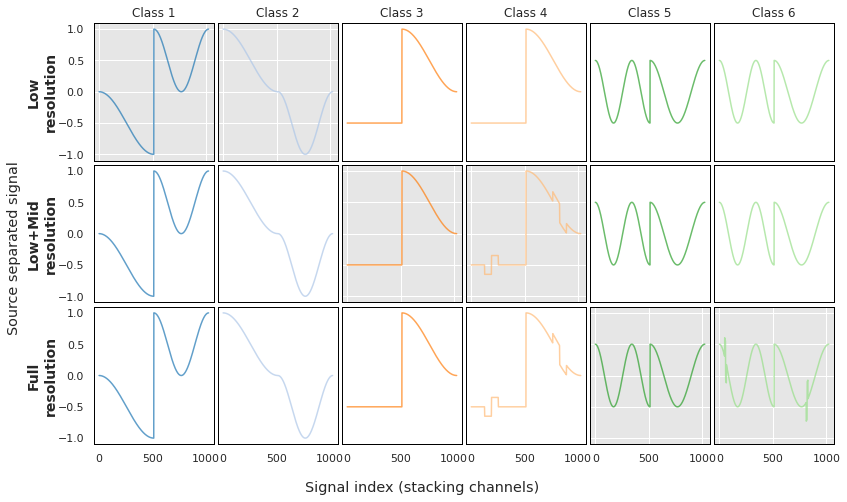

In [5]:
g = sns.FacetGrid(df, col="class", row="resolution", hue="class", margin_titles=True, despine=False, height=2.5, aspect=0.8)
g.map(sns.lineplot, "loci", "signal", alpha=.7)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="Class {col_name}", row_template="")    # {row_name}

for ax,l in zip(g.axes[:,0], ["Low\nresolution", "Low+Mid\nresolution", "Full\nresolution"]):
    ax.set_ylabel(l, fontweight='bold', fontsize=14, rotation=90)  #      ha='right', va='center'
    ax.yaxis.set_label_coords(-0.3, 0.5)

    
g.set_xlabels(label="", clear_inner=True, )
# g.set_ylabels(label="", clear_inner=True, )
g.fig.supxlabel("Signal index (stacking channels)")
g.fig.supylabel("Source separated signal")

for ax in g.axes.flatten():
    for _, spine in ax.spines.items():
        spine.set_visible(True) 
        spine.set_color('black')
        spine.set_linewidth(1)
        
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Low-resolution" and (col_val == 1 or col_val == 2):
        ax.set_facecolor(".9")
    elif row_val == "Mid-resolution" and (col_val == 3 or col_val == 4):
        ax.set_facecolor(".9")
    elif row_val == "High-resolution" and (col_val == 5 or col_val == 6):
        ax.set_facecolor(".9")
    else:
        ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
plt.gcf().set_size_inches(12, 7)
plt.savefig("toy1.png", dpi=500, format='png')

# Visualise Wave-LSTM model output

In [6]:
with open("output-hpc-demo-clf.pkl", 'rb') as file:
    meta_results = pkl.load(file)

J = len(meta_results["hidden"])
lbls = meta_results["labels"].cpu().numpy()

Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
Mflat = torch.flatten(meta_results["M"], start_dim=1).cpu().numpy()
A = meta_results["attention"]

print(meta_results.keys())

dict_keys(['masked_inputs', 'hidden', 'attention', 'M', 'labels'])


## UMAP of the scale embeddings, and masked inputs

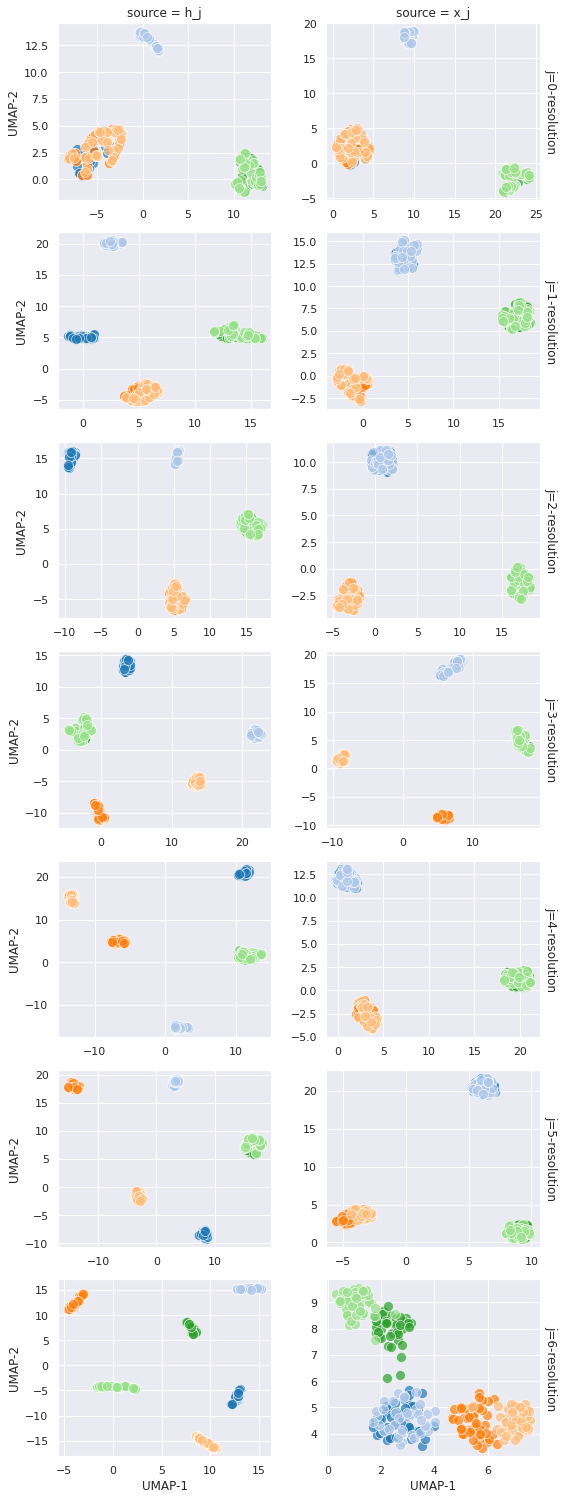

In [7]:
data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j}-resolution" for j in range(J)]): 

    h_j = meta_results["hidden"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # UMAP of scale embeddings, alpha_j prediction, and masked input
    for val, val_name in zip([h_j, x_j], ["h_j", "x_j"]):
    
        reducer = umap.UMAP()
        scaled_val = StandardScaler().fit_transform(val.reshape((val.shape[0], -1)))
        embedding = reducer.fit_transform(scaled_val)

        for i in range(embedding.shape[0]):
            data.append([embedding[i, 0], embedding[i, 1], 
                         val_name,
                         j_name, lbls[i] + 1])  

df_emb = pd.DataFrame(data, columns=["UMAP-1", "UMAP-2", "source", "resolution", "class"])
df_emb.head()

# Plot
g = sns.FacetGrid(df_emb, row="resolution", col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")

## Plot selective resolution embeddings

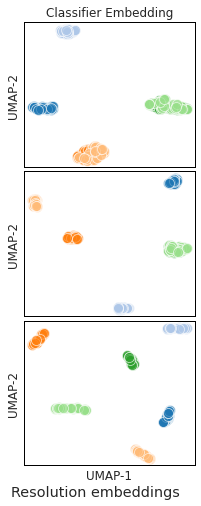

In [8]:
resolutions = [1,4,6]
sources = ["h_j"]

df_fig1 = df_emb[df_emb["resolution"].isin([f"{i}-resolution" for i in resolutions])]
df_fig1 = df_fig1[df_fig1["source"].isin(sources)]
# df_fig1 = df_fig1[df_fig1["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.FacetGrid(df_fig1, row="resolution", col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="Classifier Embedding", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label="UMAP-1", clear_inner=True, )
g.set_ylabels(label="UMAP-2", clear_inner=True, )
g.fig.supxlabel("Resolution embeddings")

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
# plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
plt.gcf().set_size_inches(3.5, 7)
        
plt.savefig("classifier_embeddings.png", dpi=500, format='png', transparent=True)

## Visualisation of self-attention (in paper)

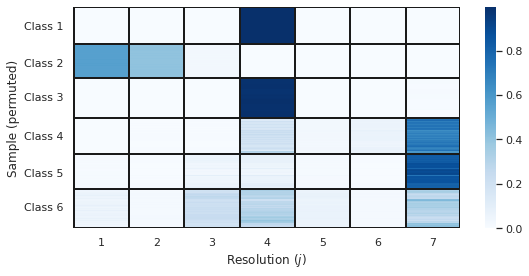

In [9]:
from sklearn.cluster import SpectralBiclustering

# Order samples by label
permute_idx = np.argsort(lbls)
ord_lbls = lbls[permute_idx]
ord_attention = A[permute_idx, :, :]

# average over attention hops:   [batch_size, num_multiscales]
ord_attention = torch.mean(ord_attention, dim=1).cpu().numpy()  

# Nested ordering (by biclustering attention)
attention_new = np.zeros_like(ord_attention)
for _lbl in np.unique(ord_lbls):
    lbl_idx = np.where(ord_lbls == _lbl)[0]
    atn_cls = ord_attention[lbl_idx, :]
    biclustering = SpectralBiclustering(n_clusters=(ord_attention.shape[1], 1), method="log", random_state=0)
    biclustering.fit(atn_cls)
    atn_cls = atn_cls[np.argsort(biclustering.row_labels_)]
    attention_new[lbl_idx, :]  = atn_cls#[:, np.argsort(biclustering.column_labels_)]
attention = attention_new

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.heatmap(attention, ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1

# Add horizontal lines
y_tick_locations = [np.where(ord_lbls == _lbl)[0][0] for _lbl in np.unique(ord_lbls)]
for y_tick in y_tick_locations:
    ax.hlines(y=y_tick+0.1, xmin=0, xmax=20, linewidth=2, color='k')
ax.hlines(y=attention.shape[0]-0.1, xmin=0, xmax=20, linewidth=2, color='k')

# Add vertical lines
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')
ax.vlines(x=attention.shape[1]-0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')

    
ax.set_yticks([yi+attention.shape[0]/12 for yi in y_tick_locations])
# ax.set_yticks([], minor=True)
# ax.yaxis.grid(True, which='major', lw=1, ls='-', color='k')
ax.set_yticklabels([f"Class {i+1}" for i in np.unique(ord_lbls)])
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)

ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Sample (permuted)")

plt.tight_layout()
plt.savefig("classifier_attention.png", dpi=500, format='png', transparent=True)

## Visualisation of the multi-resolution embedding

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


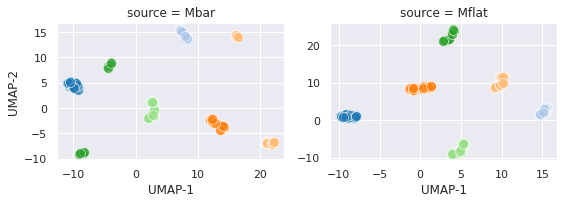

In [10]:
data = []

# UMAP of scale embeddings, alpha_j prediction, and masked input
for val, val_name in zip([Mbar, Mflat], ["Mbar", "Mflat", ""]):

    reducer = umap.UMAP()
    scaled_val = StandardScaler().fit_transform(val.reshape((val.shape[0], -1)))
    embedding = reducer.fit_transform(scaled_val)

    for i in range(embedding.shape[0]):
        data.append([embedding[i, 0], embedding[i, 1], 
                     val_name,
                     lbls[i] + 1])  

df_emb = pd.DataFrame(data, columns=["UMAP-1", "UMAP-2", "source", "class"])
df_emb.head()

# Plot
g = sns.FacetGrid(df_emb, col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)


## Plot flattened multi-resolution embeddings (in paper)

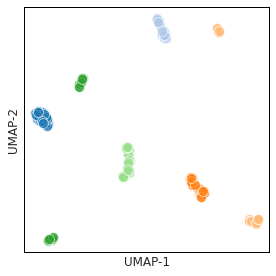

In [11]:
sources = ["Mbar"]

df_emb = df_emb[df_emb["source"].isin(sources)]
# df_emb = df_emb[df_emb["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.FacetGrid(df_emb,  col="source", hue="class", margin_titles=True, despine=False, height=4, aspect=1, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label="UMAP-1", clear_inner=True, )
g.set_ylabels(label="UMAP-2", clear_inner=True, )

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
plt.tight_layout()
        
plt.savefig("classifier_mflat.png", dpi=500, format='png', transparent=True)